<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(End_02_16%5D_cifar10_tutorial_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/model
!pwd

Mounted at /content/drive
/content/drive/MyDrive/model
/content/drive/MyDrive/model


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr #use of numpy
import pytorch_ssim
import math

In [ ]:
def get_psnr(input, output, max_val=1):

    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()
    img_diff = output - input
    rmse = np.mean(img_diff**2)
    
    if rmse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/rmse)
      return psnr 

In [ ]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 5000개, 10000개, 10000개
tr_dataset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.ToTensor()) 
tr_subset, val_subset = torch.utils.data.random_split(tr_dataset, [50000,10000], generator=torch.Generator().manual_seed(1))
test_set  = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor())


In [ ]:
X_train_set = tr_subset.dataset.data[tr_subset.indices]
Y_train_set = tr_subset.dataset.targets[tr_subset.indices]
X_val_set = val_subset.dataset.data[val_subset.indices]
Y_val_set = val_subset.dataset.targets[val_subset.indices]

train_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

In [ ]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환
val_set_arr = X_val_set.numpy()

In [ ]:
# Download the training and test datasets



tr_dataset = datasets.CIFAR10(root = './data', train=True,
                                  download=True, transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform= transforms.ToTensor())



tr_subset, val_subset = torch.utils.data.random_split(tr_dataset, [40000,10000], generator=torch.Generator().manual_seed(0))


#Prepare data loaders
tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=32, num_workers=0)
tr_hat_loader = torch.utils.data.DataLoader(tr_hat_subset, batch_size=32, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, num_workers=0)
val_hat_loader = torch.utils.data.DataLoader(val_hat_subset, batch_size=32, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)
test_hat_loader = torch.utils.data.DataLoader(test_hat_dataset, batch_size=32, num_workers=0)


#Utility functions to un-normalize and display an image
def imshow(img):

    plt.imshow(np.transpose(img, (1, 2, 0)), interpolation= 'nearest') 


#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images

  

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


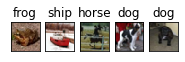

In [ ]:
dataiter = iter(tr_loader)

images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(3,3))
# display 20 images
for idx in np.arange(5):
    ax = plt.subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
wonjae = iter(tr_hat_loader)

hi,hello = wonjae.next()
hi = hi.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(3,3))
# display 20 images
for idx in np.arange(5):
    ax = plt.subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(hi[idx])
    ax.set_title(classes[labels[idx]])
  

TypeError: ignored

In [ ]:
hat_dataiter

In [ ]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    #input = 3 by 32 by 32
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 2, padding=0),
    #1nd layer_size = 8 by 15 by 15
        nn.ReLU(True),

        nn.Conv2d(in_channels =8, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
    #2nd leyar_size = 16 by 7 by 7   
        nn.ReLU(True),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2, padding = 0),
    #3nd layer_size = 32 by 3 by 3
        nn.ReLU(True),
    #   nn.Flatten(),
    #5nd layer (32, 32, 3, 3) -> (32, 32*3*3) 
    #   nn.Linear(32*3*3,10),
    #6nd layer (32, 32*3*3) -> (32, 10)
    #   nn.ReLU(True))
    )
    self.decoder = nn.Sequential(
    #   nn.Linear(10, 32*3*3),
    #    nn.ReLU(True),
    #1nd layer (32,10) -> (32,32*3*3)
    #    nn.Unflatten(1,(32,3,3)),
    #2nd layer (32, 32*3*3) -> (32, 32, 3, 3)
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2, padding =0),
        nn.ReLU(True),
    #3nd layer (batch_size, 16, 7, 7)
        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 0),
        nn.ReLU(True),
    #4nd layer (batch_size, 8, 15, 15)
        nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3, stride = 2, padding = 0, output_padding = 1),
    #5nd layer(batch_size, 3, 32, 32)
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
#Instantiate the model
model = DenosingAutoencoder()
print(model)

DenosingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [ ]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


DenosingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

Epoch: 2 	Training Loss: 0.349162	 validation Loss 0.000553
Class:cat 	 PNSR :21.698492170246702
Class:ship 	 PNSR :21.37409418645712
Class:ship 	 PNSR :20.297157314874777
Class:airplane 	 PNSR :21.053083621727207
Class:frog 	 PNSR :19.060173020770993


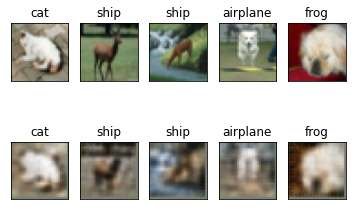

Epoch: 3 	Training Loss: 0.339240	 validation Loss 0.000540
Class:cat 	 PNSR :21.870016110491896
Class:ship 	 PNSR :21.53654337914894
Class:ship 	 PNSR :20.387648547998833
Class:airplane 	 PNSR :21.150125845806187
Class:frog 	 PNSR :19.13485645281383


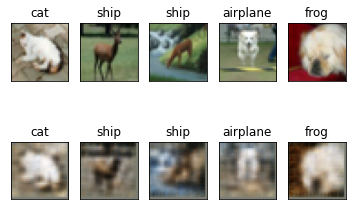

Epoch: 4 	Training Loss: 0.331662	 validation Loss 0.000531
Class:cat 	 PNSR :22.030953249799737
Class:ship 	 PNSR :21.64445315339393
Class:ship 	 PNSR :20.454673328223905
Class:airplane 	 PNSR :21.20621731467871
Class:frog 	 PNSR :19.181127776663278


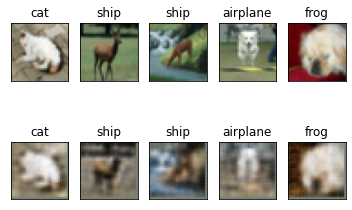

Epoch: 5 	Training Loss: 0.326171	 validation Loss 0.000525
Class:cat 	 PNSR :22.170569160245563
Class:ship 	 PNSR :21.708725399262082
Class:ship 	 PNSR :20.507600921736817
Class:airplane 	 PNSR :21.22180582874777
Class:frog 	 PNSR :19.211587376705776


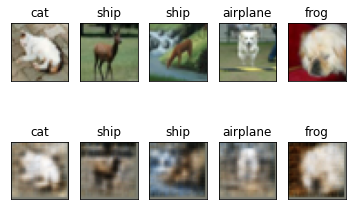

Epoch: 6 	Training Loss: 0.322211	 validation Loss 0.000520
Class:cat 	 PNSR :22.285208137565597
Class:ship 	 PNSR :21.75059322028458
Class:ship 	 PNSR :20.559160522990616
Class:airplane 	 PNSR :21.248567548563017
Class:frog 	 PNSR :19.2407995646648


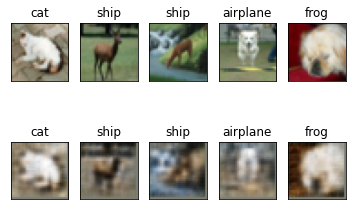

Epoch: 7 	Training Loss: 0.319018	 validation Loss 0.000517
Class:cat 	 PNSR :22.381132921209105
Class:ship 	 PNSR :21.785707161130627
Class:ship 	 PNSR :20.602402190250295
Class:airplane 	 PNSR :21.27366830049317
Class:frog 	 PNSR :19.26090810370677


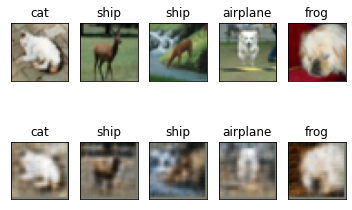

Epoch: 8 	Training Loss: 0.316310	 validation Loss 0.000512
Class:cat 	 PNSR :22.48447635139373
Class:ship 	 PNSR :21.831304964927206
Class:ship 	 PNSR :20.64819693982264
Class:airplane 	 PNSR :21.329449001472383
Class:frog 	 PNSR :19.27846142242882


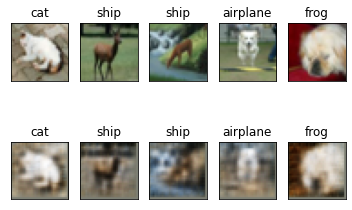

Epoch: 9 	Training Loss: 0.313846	 validation Loss 0.000507
Class:cat 	 PNSR :22.64291225423259
Class:ship 	 PNSR :21.93578750229523
Class:ship 	 PNSR :20.709782297130616
Class:airplane 	 PNSR :21.42865661410056
Class:frog 	 PNSR :19.318153599847626


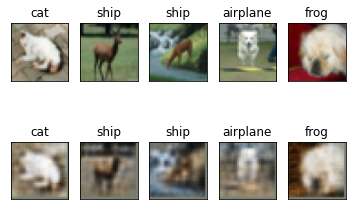

Epoch: 10 	Training Loss: 0.310478	 validation Loss 0.000498
Class:cat 	 PNSR :22.775684223606163
Class:ship 	 PNSR :22.031000380618345
Class:ship 	 PNSR :20.753238577976173
Class:airplane 	 PNSR :21.73210674712557
Class:frog 	 PNSR :19.3223468944677


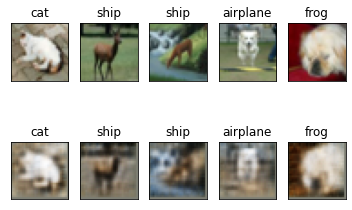

Epoch: 11 	Training Loss: 0.306847	 validation Loss 0.000496
Class:cat 	 PNSR :22.80815948805816
Class:ship 	 PNSR :22.029446624400606
Class:ship 	 PNSR :20.783563096967473
Class:airplane 	 PNSR :21.754318089441178
Class:frog 	 PNSR :19.33725191656987


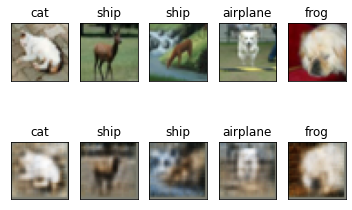

Epoch: 12 	Training Loss: 0.305143	 validation Loss 0.000493
Class:cat 	 PNSR :22.862563452921762
Class:ship 	 PNSR :22.06585123185217
Class:ship 	 PNSR :20.813737893908257
Class:airplane 	 PNSR :21.791235211873854
Class:frog 	 PNSR :19.36396598386576


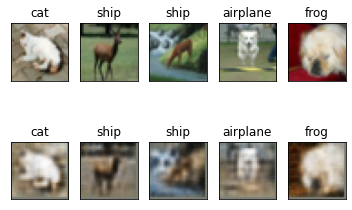

Epoch: 13 	Training Loss: 0.303826	 validation Loss 0.000490
Class:cat 	 PNSR :22.90906250623291
Class:ship 	 PNSR :22.10788662393489
Class:ship 	 PNSR :20.84410268976635
Class:airplane 	 PNSR :21.815781372944837
Class:frog 	 PNSR :19.38411659527677


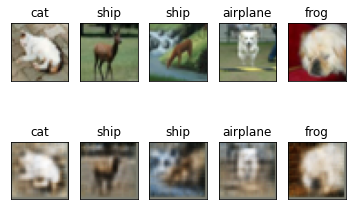

Epoch: 14 	Training Loss: 0.302711	 validation Loss 0.000486
Class:cat 	 PNSR :22.979459099740318
Class:ship 	 PNSR :22.167230526367632
Class:ship 	 PNSR :20.881094518448617
Class:airplane 	 PNSR :21.862596934760468
Class:frog 	 PNSR :19.408657251032462


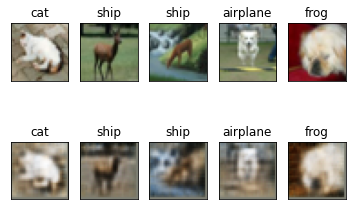

Epoch: 15 	Training Loss: 0.301709	 validation Loss 0.000486
Class:cat 	 PNSR :22.97138909765938
Class:ship 	 PNSR :22.176329077105606
Class:ship 	 PNSR :20.88456648569612
Class:airplane 	 PNSR :21.84284082127759
Class:frog 	 PNSR :19.404736354145435


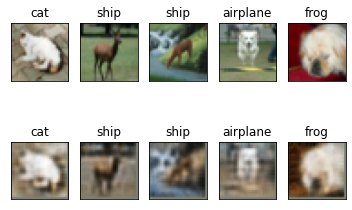

Epoch: 16 	Training Loss: 0.300898	 validation Loss 0.000484
Class:cat 	 PNSR :22.983637411418417
Class:ship 	 PNSR :22.208091930736813
Class:ship 	 PNSR :20.89711097789194
Class:airplane 	 PNSR :21.847981572168838
Class:frog 	 PNSR :19.410749867893916


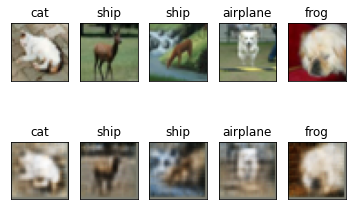

Epoch: 17 	Training Loss: 0.300191	 validation Loss 0.000483
Class:cat 	 PNSR :22.993278241834666
Class:ship 	 PNSR :22.23748841298759
Class:ship 	 PNSR :20.911656198799204
Class:airplane 	 PNSR :21.845611183619887
Class:frog 	 PNSR :19.422033889812226


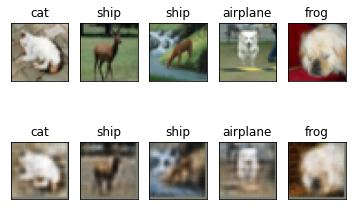

Epoch: 18 	Training Loss: 0.299567	 validation Loss 0.000480
Class:cat 	 PNSR :23.034934765722976
Class:ship 	 PNSR :22.28555282223222
Class:ship 	 PNSR :20.93319345720214
Class:airplane 	 PNSR :21.869901016666212
Class:frog 	 PNSR :19.438562791962926


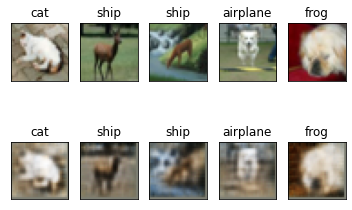

Epoch: 19 	Training Loss: 0.299001	 validation Loss 0.000479
Class:cat 	 PNSR :23.050675525900992
Class:ship 	 PNSR :22.313797458074678
Class:ship 	 PNSR :20.94296412674047
Class:airplane 	 PNSR :21.880289780805246
Class:frog 	 PNSR :19.443716226020364


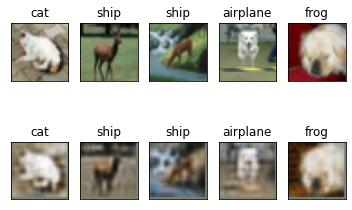

Epoch: 20 	Training Loss: 0.298493	 validation Loss 0.000478
Class:cat 	 PNSR :23.06173551049003
Class:ship 	 PNSR :22.330498855512175
Class:ship 	 PNSR :20.947270114533126
Class:airplane 	 PNSR :21.87978094444648
Class:frog 	 PNSR :19.44666180951264


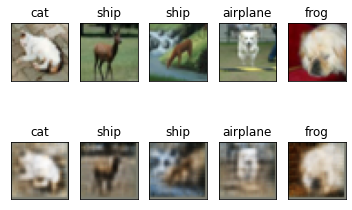

Epoch: 21 	Training Loss: 0.298031	 validation Loss 0.000478
Class:cat 	 PNSR :23.071535067125552
Class:ship 	 PNSR :22.34362030078874
Class:ship 	 PNSR :20.952241083579402
Class:airplane 	 PNSR :21.882671690567875
Class:frog 	 PNSR :19.45270838063336


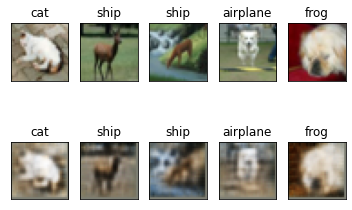

Epoch: 22 	Training Loss: 0.297599	 validation Loss 0.000477
Class:cat 	 PNSR :23.082135144273764
Class:ship 	 PNSR :22.357587466595383
Class:ship 	 PNSR :20.954879376618475
Class:airplane 	 PNSR :21.885075821354203
Class:frog 	 PNSR :19.452155005897946


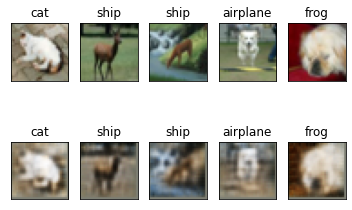

Epoch: 23 	Training Loss: 0.297212	 validation Loss 0.000476
Class:cat 	 PNSR :23.089231502945662
Class:ship 	 PNSR :22.370534564760973
Class:ship 	 PNSR :20.95647461596487
Class:airplane 	 PNSR :21.886013306150893
Class:frog 	 PNSR :19.447330583925197


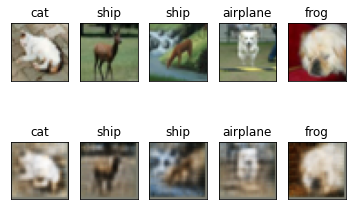

Epoch: 24 	Training Loss: 0.296861	 validation Loss 0.000476
Class:cat 	 PNSR :23.094185203211666
Class:ship 	 PNSR :22.379222782656434
Class:ship 	 PNSR :20.959750094984848
Class:airplane 	 PNSR :21.88995807866288
Class:frog 	 PNSR :19.446742997079994


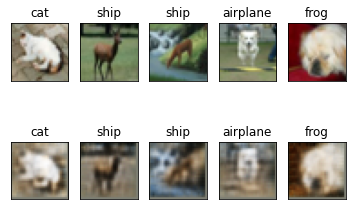

Epoch: 25 	Training Loss: 0.296534	 validation Loss 0.000475
Class:cat 	 PNSR :23.096465309018942
Class:ship 	 PNSR :22.387097188021805
Class:ship 	 PNSR :20.961988120180507
Class:airplane 	 PNSR :21.889632153219022
Class:frog 	 PNSR :19.446727685273533


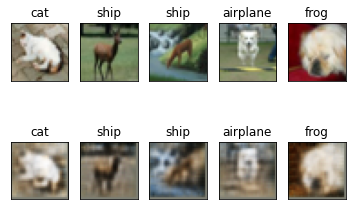

Epoch: 26 	Training Loss: 0.296227	 validation Loss 0.000475
Class:cat 	 PNSR :23.105935516964244
Class:ship 	 PNSR :22.392079930895132
Class:ship 	 PNSR :20.96409599648976
Class:airplane 	 PNSR :21.89018464719372
Class:frog 	 PNSR :19.446666082504663


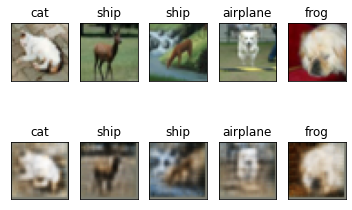

In [ ]:
#Epochs
n_epochs = 25
train_loss_graph = np.array([])
val_loss_graph = np.array([])

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    #Training
    for data in tr_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(tr_loader)
    train_loss_graph = np.append(train_loss_graph, train_loss)   
    
    if (epoch+1)%1 == 0:
          for data in val_loader:
              images, _ = data
              images = images.to(device)
              outputs = model(images)
              val_loss = criterion(outputs, images)
              val_loss += val_loss.item()*images.size(0)      
          val_loss = val_loss/len(val_loader)
          val_loss_graph = np.append(val_loss_graph, val_loss.detach().numpy())
          print('Epoch: {} \tTraining Loss: {:.6f}\t validation Loss {:.6f}'.format(epoch, train_loss, val_loss))
          
          for j in range(5):
            
            val_psnr = get_psnr(images[j], outputs[j], max_val = 1.0)
            print(f'Class:{classes[labels[j]]} \t PNSR :{val_psnr}')
            
            ax = plt.subplot(2,5,j+1)
            plt.imshow(images[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])

            ax = plt.subplot(2, 5, j+5+1)
            plt.imshow(outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])
          plt.show()

          

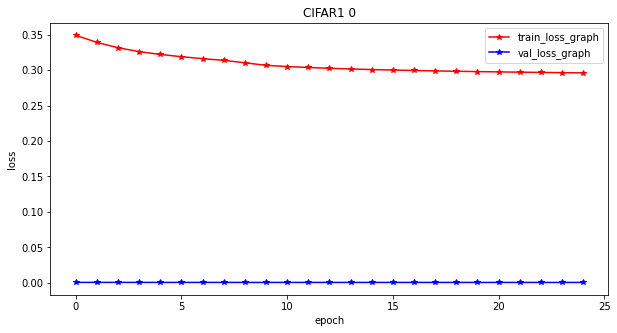

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_graph,'r-*')
plt.plot(val_loss_graph, 'b-*')
plt.legend(['train_loss_graph','val_loss_graph'])
plt.title("CIFAR1 0")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
print(images.size(0))

16


입력 이미지 크기 torch.Size([32, 3, 32, 32])
출력 이미지 크기 torch.Size([32, 3, 32, 32])
Class cat Scikit_PSNR 20.377568286707973 / Custom_PSNR 20.377568540889225
Class ship Scikit_PSNR 19.741058445439023 / Custom_PSNR 19.74105854009704
Class ship Scikit_PSNR 20.01452942285364 / Custom_PSNR 20.01452941478736
Class airplane Scikit_PSNR 21.387145665730387 / Custom_PSNR 21.387145481331284
Class frog Scikit_PSNR 19.723417105594464 / Custom_PSNR 19.723417170416568


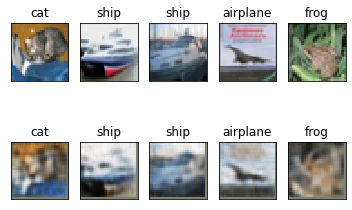

In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
images = images.to(device)
print('입력 이미지 크기',images.shape)

output = model(images)
print('출력 이미지 크기',output.shape)

images_np = images.cpu().numpy() #입력값은 그래디언 계산이 안 되었으므로(model 안 거침) detach가 필요 없다.
batch_size = 32
output=output.to(device)
output_np = output.detach().cpu().numpy()

#Original Image(5):
for idx in np.arange(5):
    PSNR_custom = get_psnr(images[idx], output[idx], max_val = 1.0)
    PSNR_scikit = psnr(images_np[idx], output_np[idx], data_range = 1.0)
#    SSIM = pytorch_ssim(images[idx],output[idx]).data
#    SSIM = ssim(images[idx], output[idx], data_range = 1.0, multichannel =True)
    print(f'Class {classes[labels[idx]]} Scikit_PSNR {PSNR_scikit} / Custom_PSNR {PSNR_custom}')
#   print(SSIM)
#    print("PSNR {:.3f}, SSIM : {.3f}",PSNR[idx], SSIM[idx])
    ax = plt.subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(classes[labels[idx]])

    ax = plt.subplot(2, 5, idx+1+5, xticks=[], yticks=[])
    imshow(output[idx].detach().cpu().numpy())
    ax.set_title(classes[labels[idx]])
plt.show() 